In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import scanpy as sc 
import sys 
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import glob
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../../src')

In [3]:
from spaceoracle.prophets import Prophet
from spaceoracle.plotting.cartography import xy_from_adata
from spaceoracle.plotting.cartography import Cartography

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode.h5ad')
adata

AnnData object with n_obs × n_vars = 22227 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram'
    uns: 'cell_thresholds', 'cell_type_colors', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_spatial', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [5]:
adata.obs.cell_type.value_counts()

cell_type
B            11832
Resting T     3660
Tfh           2095
CD8+ T        2015
Treg          1771
Th2            632
DC             222
Name: count, dtype: int64

In [41]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=50)

In [44]:
sc.tl.umap(adata, min_dist=1.0, spread=0.5)

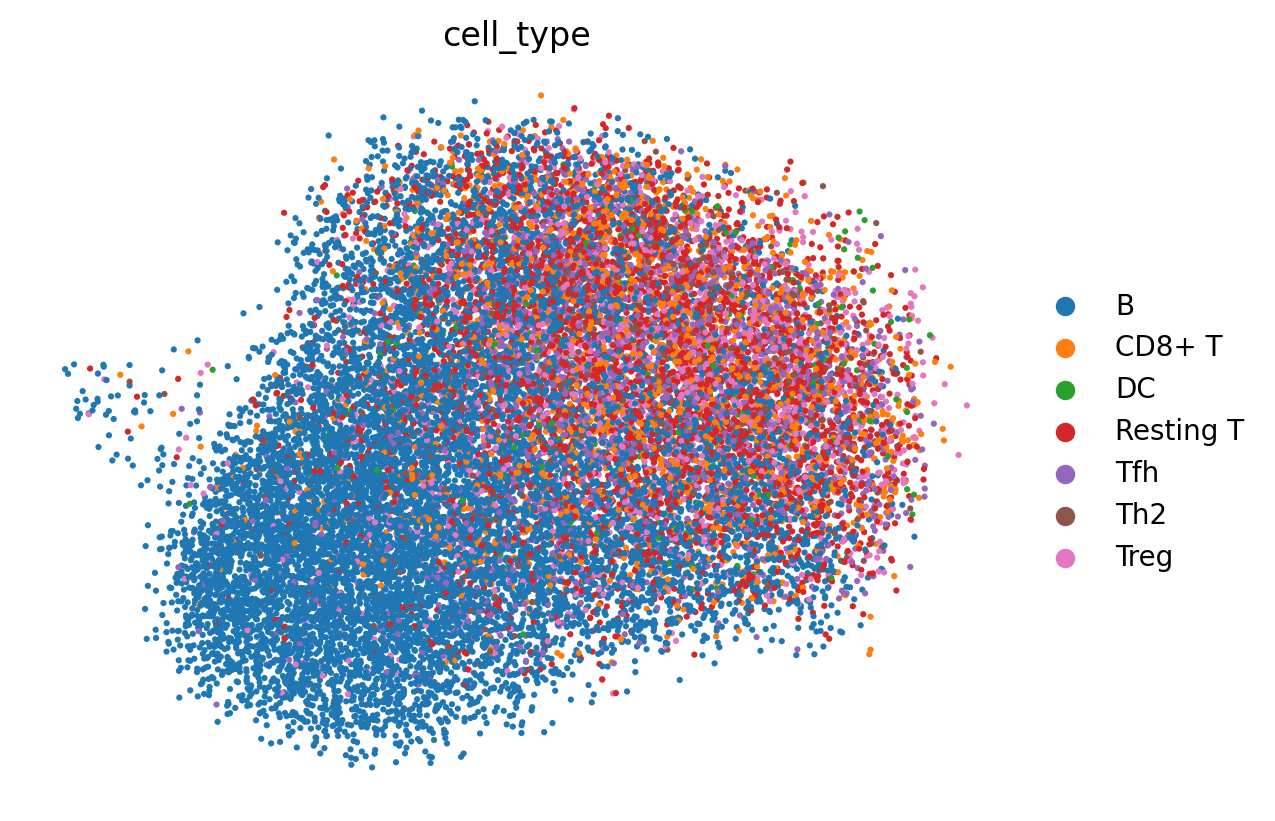

In [89]:
sc.pl.umap(adata, 
    frameon=False, color='cell_type', s=20)

In [75]:
adata.obs.cell_type.value_counts()

cell_type
B            11832
Resting T     3660
Tfh           2095
CD8+ T        2015
Treg          1771
Th2            632
DC             222
Name: count, dtype: int64

In [99]:
xy = xy_from_adata(adata)

In [226]:
from collections import defaultdict

In [128]:
[i for i in files if 'Cd' in i]

['Cd22', 'Cd44', 'Cd47', 'Cd4', 'Cd52', 'Cd74', 'Cd8a', 'Cd8b1']

In [227]:
files = glob.glob('/Volumes/SSD/lasso_runs/slideseq_mouse_lymphnode/*_betadata.parquet')

In [251]:
len(files)

1924

In [261]:
beta_records = defaultdict(list)

for f in tqdm(files):
    gene_name = f.split('/')[-1].replace('_betadata.parquet', '')
    beta = pd.read_parquet(f)
    beta = beta.join(adata.obs.cell_type).query('cell_type=="Th2"').drop(columns=['cell_type'])

    for k, v in beta[[i for i in beta.columns if '$' in i]].mean().to_dict().items():
        if abs(v) > 0:
            beta_records[k].append((gene_name, v))

  0%|          | 0/1924 [00:00<?, ?it/s]

In [295]:
interactions =pd.DataFrame([(k, gene, beta) for k, gene_beta_pairs in beta_records.items() for gene, beta in gene_beta_pairs], 
             columns=['interaction', 'gene', 'beta'])

In [296]:
interactions[['interaction', 'gene', 'beta']].copy()
interactions['ligand'] = interactions['interaction'].str.split('_').str[1].str.split('$').str[0]
interactions['receptor'] = interactions['interaction'].str.split('_').str[1].str.split('$').str[1]
interactions = interactions[['ligand', 'receptor', 'gene', 'beta']]

In [309]:
interactions.query('ligand=="Lgals9"').beta.sum()

-0.2686495788922588

In [363]:
interactions.query('ligand.isin(["Lgals9"])').sort_values(by='beta', ascending=False, key=abs).head(20)

ligand receptor    gene      beta
2575  Lgals9     Ighm    Thy1 -0.049836
2240  Lgals9    Ptprc    Lyz2 -0.038684
2383  Lgals9     Ighm   Ccl22 -0.030477
2550  Lgals9     Ighm  S100a6  0.030458
2141  Lgals9    Ptprc    Ccl8 -0.029593
2378  Lgals9     Ighm      C3  0.029496
2515  Lgals9     Ighm  Nsmce1 -0.029052
2425  Lgals9     Ighm  Eef1b2 -0.028818
2464  Lgals9     Ighm   Il2ra -0.028089
2113  Lgals9    Ptprc    Apoe -0.023790
2578  Lgals9     Ighm  Tmsb4x -0.023745
2524  Lgals9     Ighm   Pfdn5  0.022290
2504  Lgals9     Ighm     Ncl  0.021233
2197  Lgals9    Ptprc    Fth1 -0.020935
2233  Lgals9    Ptprc  Lgals3 -0.020904
2292  Lgals9    Ptprc    Psap -0.019002
2415  Lgals9     Ighm  Cxcl13  0.018472
2480  Lgals9     Ighm    Ly6a  0.018238
2156  Lgals9    Ptprc    Cd74 -0.017998
2537  Lgals9     Ighm   Psmb4 -0.017554

In [10]:
files = [i.split('/')[-1].split('_')[0] for i in glob.glob('/Volumes/SSD/genome_screens/slideseq_mouse_lymphnode/*.parquet')]

In [13]:
from tqdm.autonotebook import tqdm

In [14]:
ko_data = []

for kotarget in tqdm(files):
    data = pd.read_parquet(f'/Volumes/SSD/genome_screens/slideseq_mouse_lymphnode/{kotarget}_4n_0x.parquet')
    data = data.loc[adata.obs_names] - adata.to_df(layer='imputed_count')
    data = data.join(adata.obs.cell_type).groupby('cell_type').mean().abs().mean(axis=1)

    ds = {}
    for k, v in data.sort_values(ascending=False).to_dict().items():
        for cell_type in k.split(' | '):
            ds[cell_type] = v

    data = pd.DataFrame.from_dict(ds, orient='index')
    data.columns = [kotarget]
    ko_data.append(data)

  0%|          | 0/217 [00:00<?, ?it/s]

In [15]:
ko_concat = pd.concat(ko_data, axis=1)

In [40]:
ko_concat[['Il2', 'Il2ra', 'Gata3']]

Il2     Il2ra     Gata3
B          0.000002  0.000001  0.000221
Treg       0.000002  0.000028  0.000880
Tfh        0.000003  0.000008  0.000489
Resting T  0.000002  0.000003  0.000180
Th2        0.000002  0.000033  0.000899
CD8+ T     0.000002  0.000003  0.000145

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [26]:
ko_concat = ko_concat.drop('DC')

In [27]:
ko_concat_norm = pd.DataFrame(
    StandardScaler().fit_transform(ko_concat), 
    index=ko_concat.index, 
    columns=ko_concat.columns
)

In [28]:
ko_concat_norm[['Pax5', 'Bcl6', 'Gata3', 'Prdm1']]

Pax5      Bcl6     Gata3     Prdm1
B          2.060896  1.506758 -0.781593 -1.135967
Treg      -0.278672  0.908715  1.294337  0.939427
Tfh       -0.253284  0.171824  0.062659  0.523648
Resting T -0.971602 -1.234154 -0.911396 -1.411044
Th2        0.227086 -0.209796  1.356018  1.239945
CD8+ T    -0.784423 -1.143347 -1.020026 -0.156009

In [443]:
color_dict = {
    'B': '#9e18f1',
    'Resting T': '#a5b146',
    'Tfh': '#1032ee',
    'CD8+ T': '#9a6834',
    'Treg': '#5db852',
    'Th2': '#cd4263',
    'DC': '#5d6cb1',
}

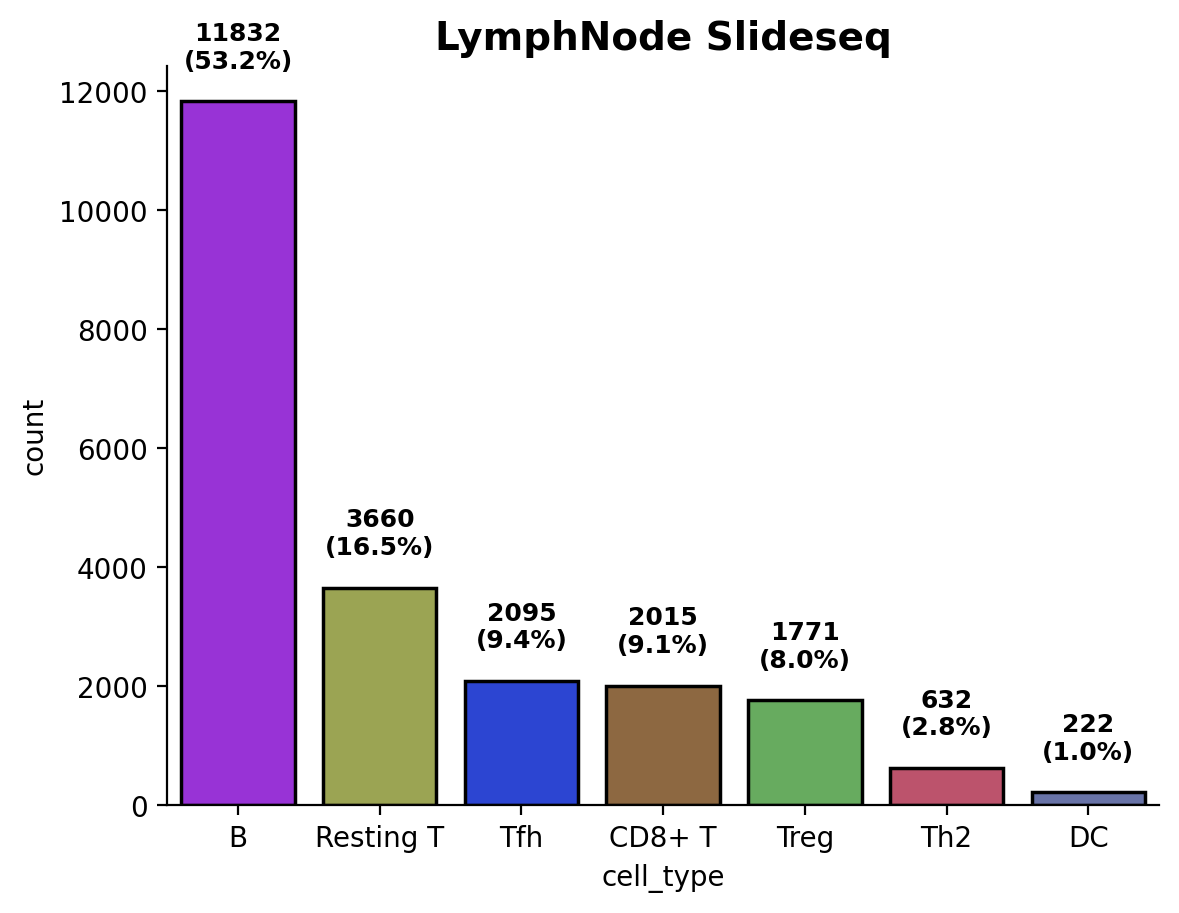

In [422]:
ax = sns.barplot(data=adata.obs.cell_type.value_counts(), 
palette=color_dict, linewidth=1.25, edgecolor='black', 
order=adata.obs.cell_type.value_counts().index)

for i, p in enumerate(ax.patches):
    count = adata.obs.cell_type.value_counts().values[i]
    percent = 100 * count / adata.obs.cell_type.value_counts().sum()
    ax.annotate(f'{count}\n({percent:.1f}%)\n', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('LymphNode Slideseq', fontsize=14, fontweight='bold')
plt.show()

In [452]:
[i for i in ko_concat_norm.columns if 'Il' in i]

['Il15',
 'Il15ra',
 'Il16',
 'Il1b',
 'Il1r1',
 'Il1rap',
 'Il27',
 'Il2',
 'Il2ra',
 'Il2rb',
 'Il2rg',
 'Il33',
 'Il4',
 'Il4ra',
 'Il6st']

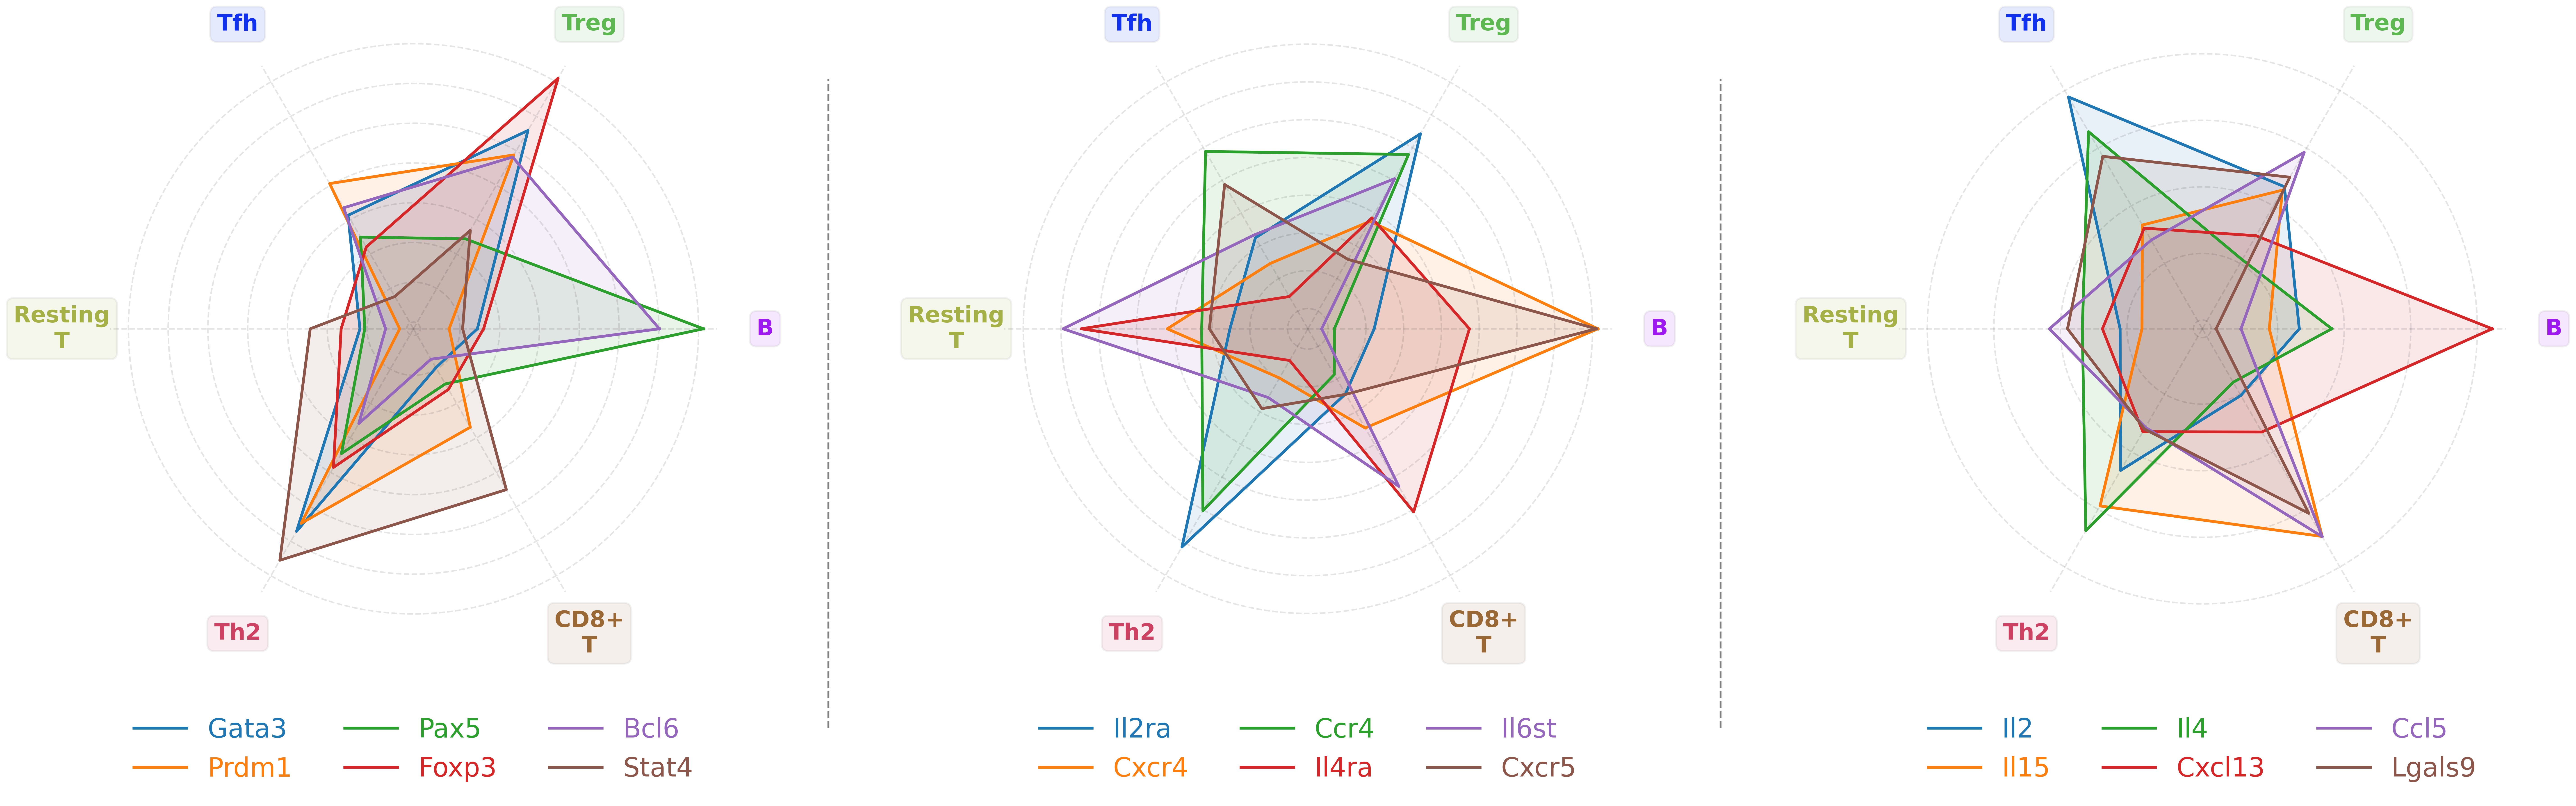

In [454]:
ligands = ['Il2', 'Il15', 'Il4', 'Cxcl13', 'Ccl5', 'Lgals9']
receptors = ['Il2ra', 'Cxcr4', 'Ccr4', 'Il4ra', 'Il6st', 'Cxcr5']
tf = ['Gata3', 'Prdm1', 'Pax5', 'Foxp3', 'Bcl6', 'Stat4']

fig, axs = plt.subplots(1, 3, 
        figsize=(20, 6), dpi=300, 
        subplot_kw={'projection': 'polar'})
axs = axs.flatten()

for ax, geneset in zip(axs, [tf, receptors, ligands]):
    for i, col in enumerate(geneset):
        values = ko_concat_norm[col].values.tolist()
        values += values[:1]  # Repeat first value to close polygon
        
        angles = np.linspace(0, 2*np.pi, len(ko_concat_norm.index), endpoint=False)
        angles = np.concatenate((angles, [angles[0]]))  # Repeat first angle to close polygon

        ax.plot(angles, values, '-', linewidth=1.5, 
                label=col, 
                # color=colors[i]
            )
        ax.fill(angles, values, alpha=0.1, 
            edgecolor='black', 
            # color=colors[i], 
            linewidth=0.5, hatch='')
        

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(
        ko_concat_norm.index.str.replace(' ', '\n'), size=12,
        fontweight='bold',
    )

    for t in ax.get_xticklabels():
        txt = t.get_text()
        t.set_color(color_dict[txt.replace('\n', ' ')])
        t.set_fontweight('bold')
        t.set_bbox(dict(boxstyle="round,pad=0.3", 
            fc=color_dict[txt.replace('\n', ' ')], ec="gray", alpha=0.1))
    ax.set_rlabel_position(0)
    ax.tick_params(pad=15)

    ax.grid(True, alpha=0.1, linestyle='--', color='black')
    ax.set_yticklabels(labels=ax.get_yticks(), size=5)

    ax.spines['polar'].set_visible(False)
    legend = ax.legend(bbox_to_anchor=(0.5, -0.1), 
        loc='upper center', ncol=3, frameon=False, fontsize=14)
    for text, line in zip(legend.get_texts(), legend.get_lines()):
        text.set_color(line.get_color())
    ax.set_rlabel_position(35)
    ax.set_yticklabels([])

# Add dividers between subplots
for i in range(1, len(axs)):
    fig.add_artist(plt.Line2D([0.33*i, 0.33*i], [0.1, 0.9], 
                             transform=fig.transFigure, color='black', 
                             linestyle='--', linewidth=1, alpha=0.5))
plt.tight_layout()
plt.show()

In [457]:
extra = pd.read_csv('banksy_cluster.csv', index_col=0)

In [461]:
extra

0         1  banksy_cluster
GGAAAACCCCGAGG  1.154593  0.673981               4
TTTTTTACATCATC -0.827062  1.314246              11
TCAAGGAATGTGCT  1.145213  2.020240               4
CGATGTGAATCTAC -1.030127  7.938298               0
CATCGGACTAGCCC -1.129358  8.806414               0
...                  ...       ...             ...
TGGACCGTGACAGA  2.773139  9.058242               7
CTTTCTTCTGTACT  2.940257  9.146934               7
CTCCATGGCATTCC  2.352166  9.501703               7
CGCGGACCTCGCGC  2.380784  9.638560               7
AGCCTGGTATTGGT  3.020920  9.199532               7

[22227 rows x 3 columns]

In [460]:
adata.obs = adata.obs.join(extra.banksy_cluster)

In [468]:
adata.obs['banksy_cluster'] = adata.obs['banksy_cluster'].astype('category')

In [463]:
adata.obsm['X_umap'] = extra[['0', '1']].values

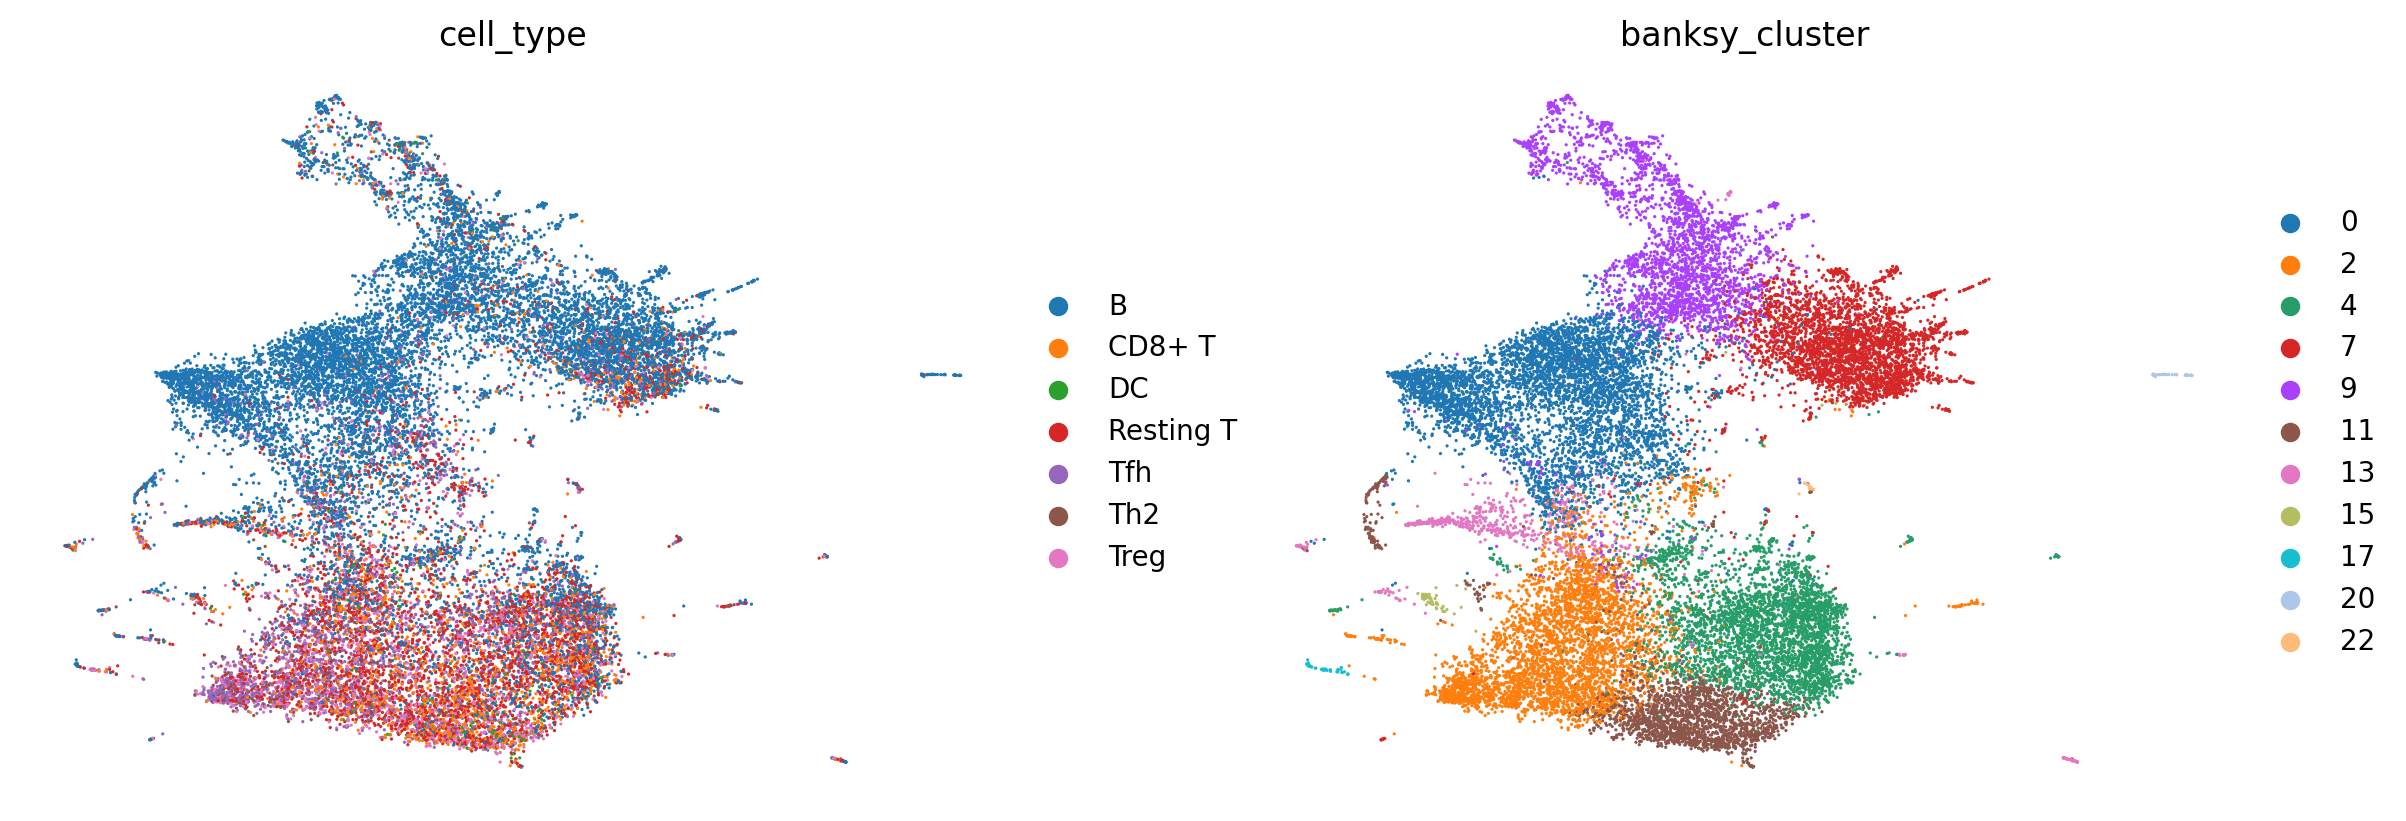

In [470]:
sc.pl.umap(adata, color=['cell_type', 'banksy_cluster'], frameon=False)

In [1]:
chart = Cartography(adata[adata.obs.cell_type.isin(['B'])], color_dict)

NameError: name 'Cartography' is not defined

In [487]:
chart.adata.obs.cell_type.value_counts()

cell_type
Treg    1771
Name: count, dtype: int64

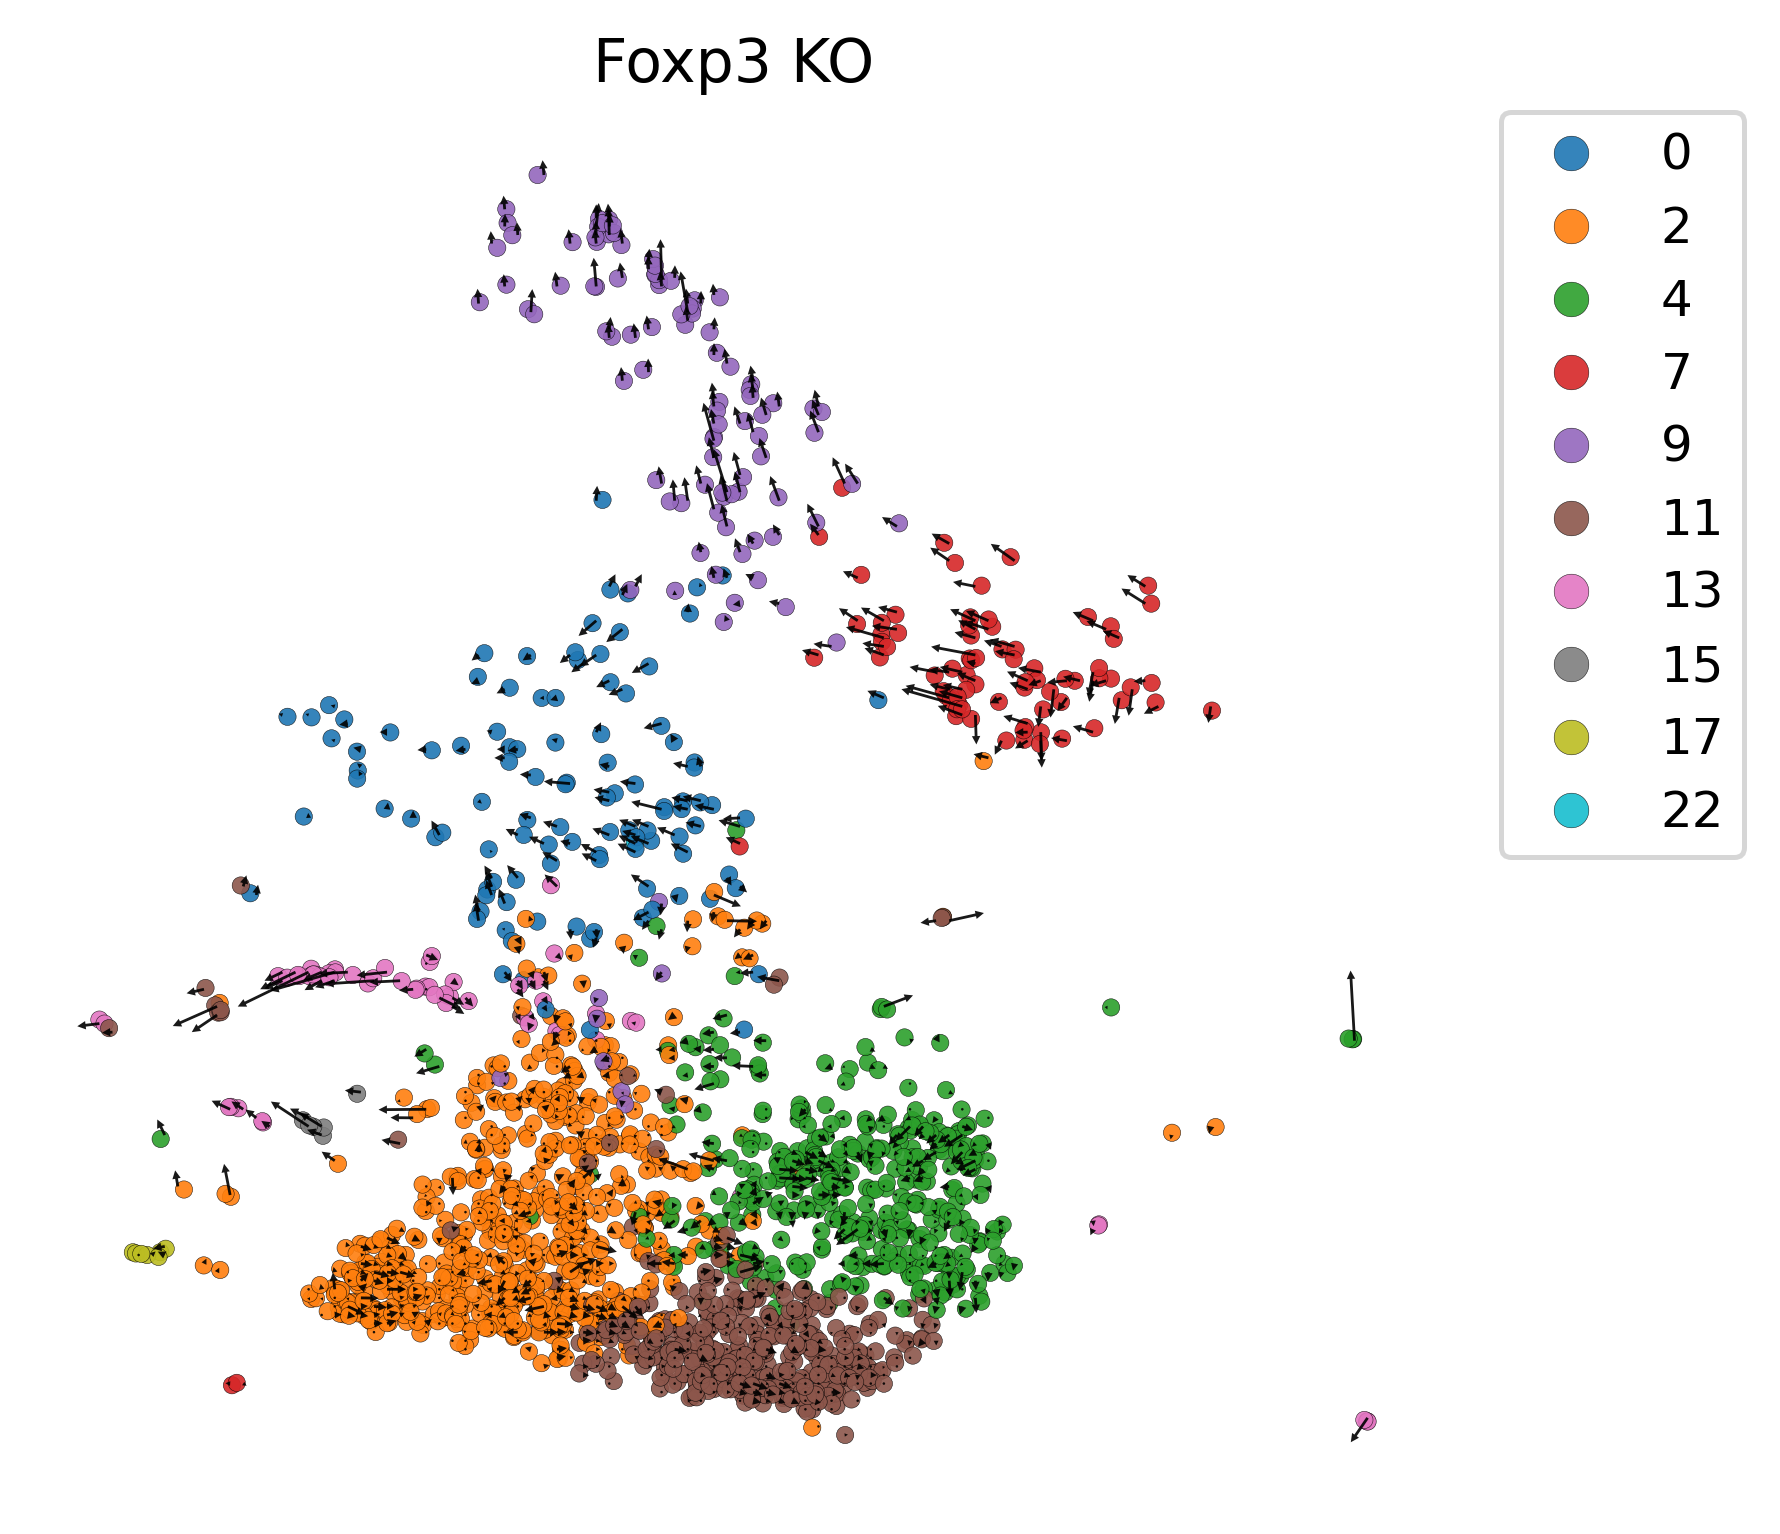

In [493]:
kotarget = 'Foxp3'
ax = chart.plot_umap_quiver(
    perturb_target=kotarget,
    grid_scale=3,
    vector_scale=0.8,
    figsize=(5, 5), 
    n_neighbors=100,
    hue='banksy_cluster',
    alpha=0.9,
    remove_null=True,
    scatter_size=12,
    betadata_path='/Volumes/SSD/genome_screens/slideseq_mouse_lymphnode',
    legend_on_loc=False,
    rescale=1e12
)
plt.title(f'{kotarget} KO')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., markerscale=2)
plt.show()

In [495]:
from spaceoracle.plotting.shift import estimate_transition_probabilities

embedding = adata.obsm['X_umap']
n_neighbors = 200
kotarget = 'Foxp3'
betadata_path = '/Volumes/SSD/genome_screens/slideseq_mouse_lymphnode'
perturbed_df = pd.read_parquet(
    f'{betadata_path}/{kotarget}_4n_0x.parquet')
delta_X = perturbed_df.loc[
    chart.adata.obs_names].values - chart.adata.layers['imputed_count']
chart.adata.layers[kotarget] = perturbed_df.loc[chart.adata.obs_names].values.copy()
corr = chart.get_corr(kotarget)
P = estimate_transition_probabilities(
    adata, delta_X, embedding, n_neighbors=n_neighbors, n_jobs=1)
del chart.adata.layers[kotarget]

: 

In [122]:
chart.adata.obs

cell_type   author_cell_type cell_type_int leiden leiden_R  \
NAME                                                                            
AAACCCAAGCGCCTTG-1   T cells              T_CD4             7      0      0,0   
AAACCCAAGTGGACGT-1    Plasma             plasma             6      4        1   
AAACCCACAGAAGTGC-1      GC B  B_germinal_center             4      5        2   
AAACCCATCATCGCAA-1  B memory           B_memory             0      7        4   
AAACCCATCCGATCGG-1    Plasma  B_germinal_center             6      4        1   
...                      ...                ...           ...    ...      ...   
TTTGTTGCAGGGACTA-1      GC B  B_germinal_center             4      5        2   
TTTGTTGCATTGTAGC-1    Plasma             plasma             6      4        1   
TTTGTTGGTACCACGC-1      GC B  B_germinal_center             4      5        2   
TTTGTTGGTCTGTCCT-1    CD4+ T              T_CD4             2      2      0,2   
TTTGTTGTCATGCGGC-1    CD4+ T              T_CD4             2      2      0,2   

                   cell_type_2      banksy_celltypes  
NAME                                                  
AAACCCAAGCGCCTTG-1    T memory                 T_CD4  
AAACCCAAGTGGACGT-1      Plasma                plasma  
AAACCCACAGAAGTGC-1        GC B         GC Light Zone  
AAACCCATCATCGCAA-1    B memory              B_memory  
AAACCCATCCGATCGG-1      Plasma  GC Intermediate Zone  
...                        ...                   ...  
TTTGTTGCAGGGACTA-1        GC B          GC Dark Zone  
TTTGTTGCATTGTAGC-1      Plasma                plasma  
TTTGTTGGTACCACGC-1        GC B          GC Dark Zone  
TTTGTTGGTCTGTCCT-1      CD4+ T                 T_CD4  
TTTGTTGTCATGCGGC-1      CD4+ T                 T_CD4  

[5139 rows x 7 columns]

In [70]:
source_ct = 'B_naive'
transition_df = chart.compute_transitions(corr, source_ct=source_ct)

In [71]:
chart.assess_transitions(
    transition_df, 
    base_celltypes=adata.obs.banksy_celltypes, 
    source_ct=source_ct
)

Source Cells: B_naive           min      mean       max
Transition Target                                      
B_naive                3.420945e-10  0.000699  0.001233
B_memory               2.023134e-10  0.000471  0.001060
pDC                    8.469155e-09  0.000053  0.010310
FDC                    4.030107e-10  0.000033  0.002592
T_CD4                  3.030271e-09  0.000030  0.000899
mDC/myeloid            1.258382e-09  0.000025  0.000575
T_CD8                  2.063119e-09  0.000024  0.003378
T_follicular_helper    2.426093e-10  0.000020  0.001501
GC Dark Zone           1.718281e-12  0.000008  0.000361
GC Light Zone          9.751556e-12  0.000007  0.000797
plasma                 8.685132e-12  0.000006  0.000128
GC Intermediate Zone   5.938835e-13  0.000006  0.000480

In [36]:
thresh = 0.00045 # need to cross this to leave base cell phenotype
allowed_fates = [
    # 'T_CD4',
    'plasma',
    'GC Light Zone',
    'B_memory',
    'GC Intermediate Zone',
    # 'T_follicular_helper',
    'GC Dark Zone',
    # 'FDC',
    'B_naive',
    # 'T_CD8',
    # 'mDC/myeloid',
    # 'pDC'
]

transitions = chart.get_cellfate(transition_df, allowed_fates, thresh)

100%|██████████| 274/274 [00:03<00:00, 84.11it/s]

Counter({'B_memory': 184, 'plasma': 70, 'GC Dark Zone': 17, 'B_naive': 2, 'GC Light Zone': 1}) 0.0004521653387598443


In [37]:
projection_params = {
    'basis': 'spatial',
    'color': 'banksy_celltypes', 
    'legend_loc': 'right',
    'recompute': True,
    'stream': False,
    'scale': 0.8,
    'alpha': 0.6,
    'size': 50,
    'show': False,
    'linewidth': 0.1,
    'palette': color_dict,
    'min_mass': 50,
    'smooth': 1.0,
    'edgecolor': 'none',
    'arrow_color':'black',
    'n_neighbors': 100,
}

In [38]:
%%capture
X_grid, V_grid = chart.get_grids(P, projection_params)
vector_field_df = chart.vector_field_df(X_grid, V_grid)


In [39]:
import alphashape

In [40]:
source_cells = adata.obs[adata.obs['banksy_celltypes'] == source_ct].index

In [41]:
adata.obs['transition'] = adata.obs['banksy_celltypes'].copy()
adata.obs.loc[source_cells, 'transition'] = np.array(transitions)
ct_points_wt, ct_points_ko = chart.make_celltype_dict()

In [42]:
delta_df = adata.to_df(layer='FOXO1') - adata.to_df(layer='imputed_count')


In [44]:
alpha_shape_1 = alphashape.alphashape(ct_points_wt['GC Light Zone'], alpha=0.04)
alpha_shape_2 = alphashape.alphashape(ct_points_wt['GC Dark Zone'], alpha=0.04)
alpha_shape_3 = alphashape.alphashape(ct_points_wt['GC Intermediate Zone'], alpha=0.04)

In [212]:
# fig, ax = plt.subplots(figsize=(10, 10), dpi=120)
# data = xy.join(adata.obs)
# source_data = data[data.banksy_celltypes == source_ct]
# transition_data = data.loc[source_cells]

# scatter = sns.scatterplot(
#     data=xy.join(adata.obs),
#     x='x', y='y',
#     # hue='banksy_celltypes', 
#     color='grey',
#     s=30,
#     alpha=0.3,
#     edgecolor='none',
#     # palette=color_dict,
#     ax=ax,
# )

# alpha_shape_1 = alphashape.alphashape(ct_points_ko['GC Light Zone'], alpha=0.04)
# alpha_shape_2 = alphashape.alphashape(ct_points_ko['GC Dark Zone'], alpha=0.04)
# alpha_shape_3 = alphashape.alphashape(ct_points_ko['GC Intermediate Zone'], alpha=0.04)

# zone_alpha = 0.85
# for geom in alpha_shape_1.geoms:
#     if geom.area > 5000:
#         ax.fill(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color=color_dict['GC Light Zone'], alpha=zone_alpha)
        

# for geom in alpha_shape_2.geoms:
#     if geom.area > 5000:
#         ax.fill(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color=color_dict['GC Dark Zone'], alpha=zone_alpha)

# for geom in alpha_shape_3.geoms:
#     if geom.area > 5000:
#         ax.fill(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color=color_dict['GC Intermediate Zone'], alpha=zone_alpha)

# alpha_shape_4 = alphashape.alphashape(
#     np.concatenate(
#         [ct_points_wt['GC Light Zone'], 
#          ct_points_wt['GC Intermediate Zone'], 
#          ct_points_wt['GC Dark Zone']]
#         ), alpha=0.03)

# for geom in alpha_shape_4.geoms:
#     if geom.area > 10000:
#         ax.plot(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color='black', alpha=zone_alpha)

# ax.set_frame_on(False)
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_xlabel('')
# ax.set_ylabel('')
# ax.set_aspect('equal')
# ax.set_xlim(data.x.min() - 10, data.x.max() + 10)
# ax.set_ylim(data.y.min() - 10, data.y.max() + 10)
# plt.show()